In [406]:
#  Import Tools
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import seaborn as sns

from sklearn import ensemble, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error
from tabulate import tabulate
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

In [172]:
# Import raw data
train_raw = pd.read_csv('D:/w266project/singledataset/traindata.csv')
test_raw = pd.read_csv('D:/w266project/singledataset/testdata.csv')

for pnl in ['pos', 'neg', 'lit']:
    for ago in ['4', '3', '2', '1', '0']:
        train_raw['pct' + pnl + ago] = train_raw['count' + pnl + ago] / train_raw['countall' + ago]
        test_raw['pct' + pnl + ago] = test_raw['count' + pnl + ago] / test_raw['countall' + ago]
        train_raw['logcount' + pnl + ago] = np.log(train_raw['count' + pnl + ago] + 1)
        test_raw['logcount' + pnl + ago] = np.log(test_raw['count' + pnl + ago] + 1)

for pnl in ['pos', 'neg', 'lit']:
    for ago in ['4', '3', '2', '1']:
        train_raw['deltapct' + pnl + ago] = train_raw['pct' + pnl + '0'] - train_raw['pct' + pnl + ago]
        test_raw['deltapct' + pnl + ago] = test_raw['pct' + pnl + '0'] - test_raw['pct' + pnl + ago]
        
for stype in ['tfidf', 'count']:
    for ago in ['4', '3', '2']:
        train_raw['deltasim' + stype + ago] = train_raw['sim' + stype + '1'] - train_raw['sim' + stype + ago]
        test_raw['deltasim' + stype + ago] = test_raw['sim' + stype + '1'] - test_raw['sim' + stype + ago]

train_raw['stockexcessreturn0'] = train_raw['stockreturn0'] - train_raw['marketreturn0']
test_raw['stockexcessreturn0'] = test_raw['stockreturn0'] - test_raw['marketreturn0']

print('Train data: {}'.format(train_raw.shape))
print('Test data: {}'.format(test_raw.shape))
train_raw.head()

Train data: (32673, 96)
Test data: (5387, 96)


,filedate,prevfiledate,nextfiledate,simtfidf4,simtfidf3,simtfidf2,simtfidf1,simcount4,simcount3,simcount2,...,deltapctlit3,deltapctlit2,deltapctlit1,deltasimtfidf4,deltasimtfidf3,deltasimtfidf2,deltasimcount4,deltasimcount3,deltasimcount2,stockexcessreturn0
0,5/6/1994,3/11/1994,8/11/1994,0.464020,0.500892,0.339642,0.303565,0.792397,0.818084,0.680923,...,0.015921,0.011873,0.015767,-0.160455,-0.197327,-0.036077,-0.158670,-0.184358,-0.047196,-0.691820
1,6/13/1994,3/17/1994,9/9/1994,0.577542,0.119173,0.247151,0.742980,0.798722,0.293678,0.529463,...,0.027279,0.034513,0.010724,0.165438,0.623806,0.495829,0.093247,0.598291,0.362507,0.635143
2,7/12/1994,7/8/1994,8/12/1994,0.342868,0.987936,0.160693,0.522063,0.631178,0.998155,0.250790,...,0.000008,-0.008042,0.000526,0.179195,-0.465873,0.361370,0.205638,-0.161339,0.586026,0.000754
3,8/9/1994,6/29/1994,11/9/1994,0.378184,0.261474,0.819605,0.139268,0.624293,0.419147,0.943566,...,-0.003708,-0.001437,-0.025547,-0.238916,-0.122206,-0.680337,-0.282376,-0.077231,-0.601649,-0.129973
4,8/11/1994,5/6/1994,11/10/1994,0.541043,0.370449,0.322814,0.748890,0.846839,0.701664,0.636085,...,0.008738,0.012632,-0.003134,0.207847,0.378441,0.426076,0.073838,0.219014,0.284592,0.080701


In [174]:
train_raw.columns

Index(['filedate', 'prevfiledate', 'nextfiledate', 'simtfidf4', 'simtfidf3',
       'simtfidf2', 'simtfidf1', 'simcount4', 'simcount3', 'simcount2',
       'simcount1', 'countpos4', 'countpos3', 'countpos2', 'countpos1',
       'countpos0', 'countneg4', 'countneg3', 'countneg2', 'countneg1',
       'countneg0', 'countlit4', 'countlit3', 'countlit2', 'countlit1',
       'countlit0', 'countall4', 'countall3', 'countall2', 'countall1',
       'countall0', 'ticker', 'filedateobj', 'prevfiledateobj',
       'nextfiledateobj', 'stockprice0', 'stockprice1', 'stockpricefuture',
       'marketprice0', 'marketprice1', 'marketpricefuture', 'stockreturn0',
       'stockreturnfuture', 'marketreturn0', 'marketreturnfuture',
       'beatmarket0', 'beatmarketfuture', 'pctpos4', 'logcountpos4', 'pctpos3',
       'logcountpos3', 'pctpos2', 'logcountpos2', 'pctpos1', 'logcountpos1',
       'pctpos0', 'logcountpos0', 'pctneg4', 'logcountneg4', 'pctneg3',
       'logcountneg3', 'pctneg2', 'logcountneg2', '

In [173]:
train_labels = train_raw['beatmarketfuture']
test_labels = test_raw['beatmarketfuture']

fldsToDrop = ['filedate', 'prevfiledate', 'nextfiledate', 'stockprice0', 'stockprice1', 'stockpricefuture',
             'marketprice0', 'marketprice1', 'marketpricefuture', 'filedateobj', 'prevfiledateobj', 'nextfiledateobj',
             'beatmarketfuture', 'marketreturnfuture', 'stockreturnfuture', 'ticker', 
             'countpos4', 'countpos3', 'countpos2', 'countpos1', 'countpos0',
             'countall4', 'countall3', 'countall2', 'countall1', 'countall0',
             'countneg4', 'countneg3', 'countneg2', 'countneg1', 'countneg0',
             'countlit4', 'countlit3', 'countlit2', 'countlit1', 'countlit0']

train_features = train_raw.drop(fldsToDrop, axis=1)
test_features = test_raw.drop(fldsToDrop, axis=1)

print(train_features.head())
print(train_labels.head())
print(test_features.head())
print(test_labels.head())

   simtfidf4  simtfidf3  simtfidf2  simtfidf1  simcount4  simcount3  \
0   0.464020   0.500892   0.339642   0.303565   0.792397   0.818084   
1   0.577542   0.119173   0.247151   0.742980   0.798722   0.293678   
2   0.342868   0.987936   0.160693   0.522063   0.631178   0.998155   
3   0.378184   0.261474   0.819605   0.139268   0.624293   0.419147   
4   0.541043   0.370449   0.322814   0.748890   0.846839   0.701664   

   simcount2  simcount1  stockreturn0  marketreturn0         ...          \
0   0.680923   0.633727     -0.732558      -0.040738         ...           
1   0.529463   0.891969      0.609766      -0.025378         ...           
2   0.250790   0.836816     -0.002811      -0.003565         ...           
3   0.943566   0.341916     -0.107246       0.022728         ...           
4   0.636085   0.920677      0.105099       0.024397         ...           

   deltapctlit3  deltapctlit2  deltapctlit1  deltasimtfidf4  deltasimtfidf3  \
0      0.015921      0.011873      0.

In [175]:
train_X, dev_X, train_y, dev_y = train_test_split(train_features, train_labels, test_size=0.3, random_state=200)

print(train_X.shape)
print(dev_X.shape)
print(train_y.shape)
print(dev_y.shape)

(22871, 60)
(9802, 60)
(22871,)
(9802,)


In [597]:
def get_score(prediction, actual):    
    # This function prints R squared and root mean squared error
    print('R2:',r2_score(actual, prediction))
    print('RMSE:', np.sqrt(mean_squared_error(actual, prediction)), '\n')

      
def test_model(model, train_X, dev_X, train_y, dev_y, xval = False):
    # This function shows scores for train and validation sets  
    prediction_train = model.predict(train_X)
    print(model, '\n')
       
    # Print model results on training data
    print('Model results based on training data')
    get_score(prediction_train, train_y)
    
    prediction_dev = model.predict(dev_X)
    print('Model results based on dev data')
    get_score(prediction_dev, dev_y)
    

# let's verify that linear regression is totally useless
simple_LR = linear_model.LinearRegression()
simple_LR.fit(X=train_X, y=train_y)
test_model(simple_LR, train_X, dev_X, train_y, dev_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False) 

Model results based on training data
R2: 0.00447383473448
RMSE: 0.498032229415 

Model results based on dev data
R2: 0.00348927104492
RMSE: 0.498305847311 



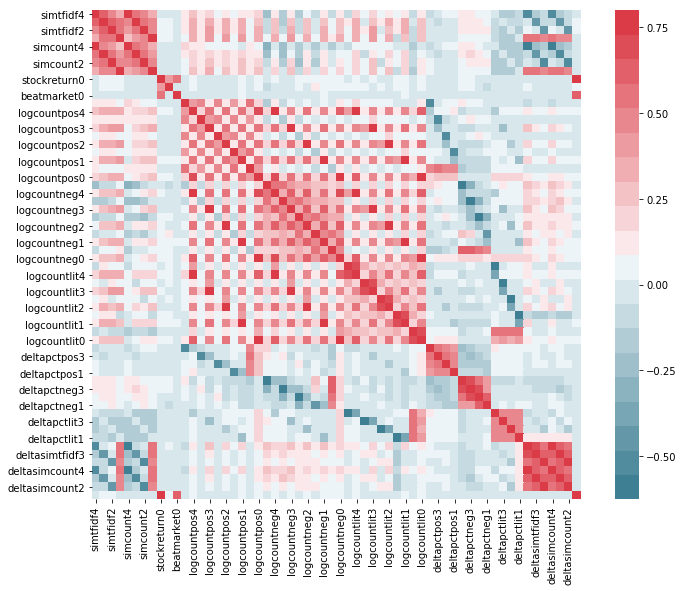

In [598]:
corrmat2 = train_features.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat2, vmax=.8, square=True, cmap=sns.diverging_palette(220, 10, sep=10, n=20))

In [154]:
#cvals = {'C': [0.00001, 0.0001, 0.001, 0.01] + [float(x+1) / 20 for x in range(20)] + [2, 5, 10, 25]}
cvals = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
lr = LogisticRegression()
grid_lr = GridSearchCV(lr, cvals, scoring='f1_macro')
grid_lr.fit(train_X.values, train_y.values)
print("Logistic Regression:")
print("Optimal C is {}".format(grid_lr.best_params_['C']))
print("f1 score for C = {} is {:.6f}"
      .format(grid_lr.best_params_['C'],
              metrics.f1_score(dev_y.values, grid_lr.predict(dev_X.values), average='macro')))

Logistic Regression:
Optimal C is 100
f1 score for C = 100 is 0.461356


In [650]:
grid_lr.best_score_

0.46457109885463238

In [446]:
np.array([5,6,7])[np.where(np.array([1,2,3]) > 1)]

array([6, 7])

In [656]:
def predictAndPrint(clf, predThis, labels):
    pred = clf.predict(predThis)
    proba = clf.predict_proba(predThis)
    predTrue = [x == 1 for x in pred.tolist()]
    predFalse = [x == 0 for x in pred.tolist()]
    isTrue = [x == 1 for x in labels.values.tolist()]
    isFalse = [x == 0 for x in labels.values.tolist()]
    tn = sum([predTrue[x] and isTrue[x] for x in range(len(pred))])
    tp = sum([predFalse[x] and isFalse[x] for x in range(len(pred))])
    fn = sum([predTrue[x] and isFalse[x] for x in range(len(pred))])
    fp = sum([predFalse[x] and isTrue[x] for x in range(len(pred))])
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    print("Predicted Count:\t{}\t{}".format(sum(pred == 1), sum(pred == 0)))
    print("Actual Count:\t\t{}\t{}".format(sum(labels == 1), sum(labels == 0)))
    print("Count Right/Wrong:\t{}\t{}".format(sum(pred == labels), sum(pred != labels)))
    print("Count Prec/Recall:\t{:.3f}\t{:.3f}".format(prec, recall))
    print("F-measure:\t\t{:.3f}".format(2 * (prec * recall) / (prec + recall)))
    print("Accuracy:\t\t{:.3f}".format((tp + tn) / (tp + tn + fp + fn)))
    print("="*40)

In [711]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_X.values, train_y.values)
knn.score(dev_X.values, dev_y.values)
predictAndPrint(knn, dev_X, dev_y)

Predicted Count:	4567	5235
Actual Count:		5182	4620
Count Right/Wrong:	4989	4813
Count Prec/Recall:	0.482	0.546
F-measure:		0.512
Accuracy:		0.509


In [710]:
nb = BernoulliNB(alpha=1)
nb.fit(train_features, train_labels)
print(nb.score(train_X.values, train_y.values))
print(nb.score(dev_X, dev_y))
predictAndPrint(nb, train_features, train_labels)
predictAndPrint(nb, test_features, test_labels)
cross_val_score(nb, train_features, train_labels)

0.527611385597
0.53325851867
Predicted Count:	25215	7458
Actual Count:		17284	15389
Count Right/Wrong:	17294	15379
Count Prec/Recall:	0.501	0.243
F-measure:		0.327
Accuracy:		0.529
Predicted Count:	4339	1048
Actual Count:		2654	2733
Count Right/Wrong:	2666	2721
Count Prec/Recall:	0.506	0.194
F-measure:		0.280
Accuracy:		0.495


array([ 0.51358795,  0.52153154,  0.50688705])

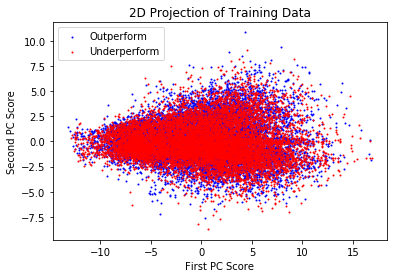

In [519]:
pca = PCA(2)
pca_2d = pca.fit_transform(train_X)
plt.scatter(pca_2d[:,0][train_y==1], pca_2d[:,1][train_y==1],
            color='b', s=1)
# Negative=red
plt.scatter(pca_2d[:,0][train_y==0], pca_2d[:,1][train_y==0],
            color='r', s=1)
plt.xlabel('First PC Score')
plt.ylabel('Second PC Score')
plt.title('2D Projection of Training Data')
plt.legend(labels=('Outperform', 'Underperform'))
plt.show()

In [567]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(100,100,100,100), random_state=42,
                    max_iter=1000, activation='relu')
clf.fit(train_X, train_y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [661]:
predictAndPrint(clf, train_X, train_y)
predictAndPrint(clf, dev_X, dev_y)
predictAndPrint(clf, test_features, test_labels)
classtrain = clf.predict(train_X)
classdev = clf.predict(dev_X)
classtest = clf.predict(test_features)
probatrain = clf.predict_proba(train_X)
probadev = clf.predict_proba(dev_X)
probatest = clf.predict_proba(test_features)
print(probatrain[0:10])
print(probadev[0:10])

print(sum(probatest[:,0] > 0.60))
print(sum(probatest[:,1] > 0.60))
print(clf.classes_)
print(classtest[np.where(probatest[:,0] > 0.60)])
print(sum(probatest[:,0] > 0.60) - sum(test_labels.values[np.where(probatest[:,0] > 0.60)]))
print(sum(test_labels.values[np.where(probatest[:,1] > 0.60)]))

Predicted Count:	14524	8347
Actual Count:		12102	10769
Count Right/Wrong:	15755	7116
Count Prec/Recall:	0.719	0.557
F-measure:		0.628
Accuracy:		0.689
Predicted Count:	6112	3690
Actual Count:		5182	4620
Count Right/Wrong:	5200	4602
Count Prec/Recall:	0.502	0.401
F-measure:		0.446
Accuracy:		0.531
Predicted Count:	4679	708
Actual Count:		2654	2733
Count Right/Wrong:	2714	2673
Count Prec/Recall:	0.542	0.141
F-measure:		0.223
Accuracy:		0.504
[[ 0.38115865  0.61884135]
 [ 0.20629635  0.79370365]
 [ 0.64808376  0.35191624]
 [ 0.3813732   0.6186268 ]
 [ 0.97183779  0.02816221]
 [ 0.04391902  0.95608098]
 [ 0.79800713  0.20199287]
 [ 0.99691351  0.00308649]
 [ 0.85639986  0.14360014]
 [ 0.50384231  0.49615769]]
[[  5.07380157e-01   4.92619843e-01]
 [  3.65031668e-01   6.34968332e-01]
 [  6.29794103e-01   3.70205897e-01]
 [  2.80507916e-01   7.19492084e-01]
 [  6.60042855e-01   3.39957145e-01]
 [  3.83247251e-01   6.16752749e-01]
 [  2.76607599e-01   7.23392401e-01]
 [  5.34026976e-07   9.999

In [769]:
thresholds = [x/100 for x in range(50,100)]

best_f = 0
best_f_acc = 0
best_t = None
best_prec = 0
best_prec_acc = 0
best_t_prec = None
for t in thresholds:
    npc = sum(probadev[:,1] > t)
    ppc = sum(probadev[:,0] > t)
    tnc = sum(dev_y.values[np.where(probadev[:,1] > t)])
    tpc = sum(probadev[:,0] > t) - sum(dev_y.values[np.where(probadev[:,0] > t)])
    fpc = ppc - tpc
    fnc = npc - tnc
    precc = tpc / (tpc + fpc)
    recallc = tpc / (tpc + fnc)
    fmeasc = 2 * (precc * recallc) / (precc + recallc)
    accc = (tpc + tnc) / (tpc + tnc + fpc + fnc)
    if fmeasc > best_f:
        best_f = fmeasc
        best_t = t
        best_acc = accc
    if precc > best_prec:
        best_prec = precc
        best_t_prec = t
        best_prec_acc = accc
    print("Minimum predicted probability is {}".format(t))
    print("Count prediction == Outperform:\t\t{}".format(npc))
    print("Count prediction == Underperform:\t{}".format(ppc))
    print("Predicted Out and actually Out:\t\t{}".format(tnc))
    print("Predicted Under and actually Under:\t{}".format(tpc))
    print("Conditional Precision:\t\t\t{:.3f}".format(precc))
    print("Conditional Recall:\t\t\t{:.3f}".format(recallc))
    print("Conditional F-measure:\t\t\t{:.3f}".format(fmeasc))
    print("Conditional Accuracy:\t\t\t{:.3f}".format(accc))
    print("="*50)

print("Best F-measure threshold:\t{}".format(best_t))
print("Produces an F-measure of\t{:.3f}".format(best_f))
print("and accuracy of \t\t{:.3f}".format(best_acc))
print("Best precision threshold:\t{}".format(best_t_prec))
print("Produces a precision of\t\t{:.3f}".format(best_prec))
print("and accuracy of \t\t{:.3f}".format(best_prec_acc))

Minimum predicted probability is 0.5
Count prediction == Outperform:		6112
Count prediction == Underperform:	3690
Predicted Out and actually Out:		3346
Predicted Under and actually Under:	1854
Conditional Precision:			0.502
Conditional Recall:			0.401
Conditional F-measure:			0.446
Conditional Accuracy:			0.531
Minimum predicted probability is 0.51
Count prediction == Outperform:		5856
Count prediction == Underperform:	3424
Predicted Out and actually Out:		3210
Predicted Under and actually Under:	1715
Conditional Precision:			0.501
Conditional Recall:			0.393
Conditional F-measure:			0.441
Conditional Accuracy:			0.531
Minimum predicted probability is 0.52
Count prediction == Outperform:		5575
Count prediction == Underperform:	3172
Predicted Out and actually Out:		3059
Predicted Under and actually Under:	1601
Conditional Precision:			0.505
Conditional Recall:			0.389
Conditional F-measure:			0.439
Conditional Accuracy:			0.533
Minimum predicted probability is 0.53
Count prediction == O

In [772]:
# test data
t = 0.64
npc = sum(probatest[:,1] > t)
ppc = sum(probatest[:,0] > t)
tnc = sum(test_labels.values[np.where(probatest[:,1] > t)])
tpc = sum(probatest[:,0] > t) - sum(test_labels.values[np.where(probatest[:,0] > t)])
fpc = ppc - tpc
fnc = npc - tnc
precc = tpc / (tpc + fpc)
recallc = tpc / (tpc + fnc)
fmeasc = 2 * (precc * recallc) / (precc + recallc)
accc = (tpc + tnc) / (tpc + tnc + fpc + fnc)
print("Minimum predicted probability is {}".format(t))
print("Count prediction == Outperform:\t\t{}".format(npc))
print("Count prediction == Underperform:\t{}".format(ppc))
print("Predicted Out and actually Out:\t\t{}".format(tnc))
print("Predicted Under and actually Under:\t{}".format(tpc))
print("Conditional Precision:\t\t\t{:.3f}".format(precc))
print("Conditional Recall:\t\t\t{:.3f}".format(recallc))
print("Conditional F-measure:\t\t\t{:.3f}".format(fmeasc))
print("Conditional Accuracy:\t\t\t{:.3f}".format(accc))

Minimum predicted probability is 0.64
Count prediction == Outperform:		567
Count prediction == Underperform:	104
Predicted Out and actually Out:		292
Predicted Under and actually Under:	59
Conditional Precision:			0.567
Conditional Recall:			0.177
Conditional F-measure:			0.269
Conditional Accuracy:			0.523


In [776]:
np.mean(test_raw.loc[np.where(probatest[:,0] > .6)]['stockreturnfuture'] -
        test_raw.loc[np.where(probatest[:,0] > .6)]['marketreturnfuture'])

-0.017446165018404909

In [775]:
np.mean(test_raw.loc[np.where(probatest[:,1] > .6)]['stockreturnfuture'] -
        test_raw.loc[np.where(probatest[:,1] > .6)]['marketreturnfuture'])

-0.0073495575082352929

In [778]:
test_raw.loc[np.where(probatest[:,1] > .6)]

,filedate,prevfiledate,nextfiledate,simtfidf4,simtfidf3,simtfidf2,simtfidf1,simcount4,simcount3,simcount2,...,deltapctlit3,deltapctlit2,deltapctlit1,deltasimtfidf4,deltasimtfidf3,deltasimtfidf2,deltasimcount4,deltasimcount3,deltasimcount2,stockexcessreturn0
4,1/8/2015,9/29/2014,4/28/2015,0.967680,0.905734,0.951616,0.933948,0.976170,0.903762,0.961941,...,-0.006580,-0.002433,-0.002996,-0.033732,0.028214,-0.017668,-0.029629,0.042779,-0.015400,0.176579
13,1/23/2015,10/24/2014,4/24/2015,0.974499,0.965262,0.957384,0.929698,0.982207,0.969113,0.953704,...,-0.002097,-0.001500,0.001827,-0.044800,-0.035564,-0.027686,-0.046725,-0.033631,-0.018222,-0.194793
18,1/27/2015,11/14/2014,4/28/2015,0.959236,0.908206,0.959375,0.951107,0.968501,0.952088,0.969854,...,-0.014692,-0.005077,-0.000488,-0.008129,0.042901,-0.008268,-0.010947,0.005466,-0.012300,0.127994
30,1/30/2015,10/24/2014,4/24/2015,0.984685,0.957020,0.955073,0.960025,0.992290,0.962994,0.959043,...,-0.003199,-0.002504,0.000772,-0.024660,0.003005,0.004952,-0.028319,0.000977,0.004928,0.195741
35,1/30/2015,10/31/2014,4/29/2015,0.987853,0.973834,0.963574,0.980021,0.992480,0.976643,0.957318,...,-0.001691,-0.000115,-0.000997,-0.007832,0.006188,0.016447,-0.011235,0.004601,0.023927,0.190714
42,2/2/2015,11/25/2014,2/4/2015,0.063610,0.093563,0.089227,0.133873,0.161889,0.225908,0.210758,...,-0.042009,-0.026406,-0.023632,0.070263,0.040310,0.044646,0.132806,0.068786,0.083937,0.247966
49,2/4/2015,10/21/2014,4/22/2015,0.990020,0.937592,0.934622,0.936785,0.995463,0.953210,0.951352,...,-0.008399,-0.011652,-0.008306,-0.053235,-0.000807,0.002162,-0.044104,-0.001851,0.000007,0.056416
59,2/5/2015,11/6/2014,5/7/2015,0.897051,0.907954,0.943786,0.967310,0.929451,0.952437,0.956304,...,-0.001917,0.001889,-0.002288,0.070258,0.059356,0.023524,0.046959,0.023973,0.020106,0.154114
63,2/5/2015,11/7/2014,5/7/2015,0.943883,0.929693,0.915844,0.850825,0.970111,0.956715,0.923610,...,0.000703,0.004049,-0.017745,-0.093058,-0.078868,-0.065019,-0.072382,-0.058987,-0.025882,-0.059864
64,2/5/2015,11/7/2014,5/7/2015,0.943883,0.929693,0.915844,0.850825,0.970111,0.956715,0.923610,...,0.000703,0.004049,-0.017745,-0.093058,-0.078868,-0.065019,-0.072382,-0.058987,-0.025882,-0.068662


In [648]:
print(167/312)
print(1627/3208)
print(sum(test_labels == True))
print(sum(test_labels == False))
print(2733 / (2733 + 2654))

0.5352564102564102
0.5071695760598504
2654
2733
0.5073324670503063


In [595]:
clf.coefs_[3]

array([[ -2.38415377e-01,   7.86718730e-02,  -3.95808191e-25, ...,
          1.02144814e-01,  -5.46332039e-06,  -8.55418273e-03],
       [  7.49003349e-03,  -5.51320988e-03,  -3.42660265e-29, ...,
         -2.01231460e-09,   7.88310491e-26,   3.82984958e-04],
       [  3.63597575e-02,   2.07441437e-01,  -3.65684509e-27, ...,
          1.09100881e-02,  -2.24239725e-04,   1.94487399e-01],
       ..., 
       [  2.11428205e-01,   1.59439910e-01,  -4.72083208e-25, ...,
          8.83417272e-03,  -5.26538389e-04,   8.01640432e-02],
       [ -3.90327397e-01,   3.04052753e-01,   4.72049814e-25, ...,
         -6.53943772e-02,  -2.62039710e-14,  -7.69726732e-02],
       [  2.84890249e-01,  -1.18204898e-01,   1.93949446e-27, ...,
         -3.90987838e-01,   3.61681102e-27,   3.84283471e-02]])

In [391]:
pred_proba = clf.predict_log_proba(test_features)
clf.score(test_features, test_labels)

0.48876925932801191

In [723]:
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(train_X, train_y)
rfc.score(train_X, train_y)
rfc.score(dev_X, dev_y)
print(rfc.predict_proba(dev_X[0:10]))
predictAndPrint(rfc, dev_X, dev_y)

[[ 0.9  0.1]
 [ 0.3  0.7]
 [ 0.3  0.7]
 [ 0.5  0.5]
 [ 0.7  0.3]
 [ 0.4  0.6]
 [ 0.2  0.8]
 [ 0.4  0.6]
 [ 0.5  0.5]
 [ 0.6  0.4]]
Predicted Count:	4350	5452
Actual Count:		5182	4620
Count Right/Wrong:	5006	4796
Count Prec/Recall:	0.484	0.571
F-measure:		0.524
Accuracy:		0.511


In [724]:
predictAndPrint(rfc, test_features, test_labels)

Predicted Count:	2835	2552
Actual Count:		2654	2733
Count Right/Wrong:	2708	2679
Count Prec/Recall:	0.511	0.477
F-measure:		0.493
Accuracy:		0.503


In [415]:
abc = AdaBoostClassifier(n_estimators=50)
abc.fit(train_X, train_y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [418]:
abc.score(train_X, train_y)
abc.score(test_features, test_labels)
print(abc.predict_proba(dev_X[0:10]))
predictAndPrint(abc, test_features, test_labels)
predictAndPrint(abc, train_X, train_y)
cross_val_score(abc, train_features, train_labels)

[[ 0.50785078  0.49214922]
 [ 0.49744918  0.50255082]
 [ 0.4999953   0.5000047 ]
 [ 0.49650547  0.50349453]
 [ 0.49977477  0.50022523]
 [ 0.49799503  0.50200497]
 [ 0.50072215  0.49927785]
 [ 0.49919553  0.50080447]
 [ 0.49968443  0.50031557]
 [ 0.49704579  0.50295421]]
Predicted Count:	4954	433
Actual Count:		2654	2733
Count Right/Wrong:	2665	2722
Count Prec/Recall:	0.493	0.920
F-measure:		0.642
Accuracy:		0.495
Predicted Count:	17001	5870
Actual Count:		12102	10769
Count Right/Wrong:	12826	10045
Count Prec/Recall:	0.560	0.787
F-measure:		0.655
Accuracy:		0.561


array([ 0.51120088,  0.51510421,  0.4902663 ])